In [1]:
import glob
import os.path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from numpy import linalg as LA
from numpy import random as rn
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [2]:
# Load the data and create a random (but reproducible) test-train split

IMAGE_DIR = "./data/data"

def load():
    file_list = glob.glob(IMAGE_DIR + "/*.jpg")
    X = []
    Y = []

    for fname in file_list:
        with Image.open(fname) as img:
            np_img = np.array(img).flatten()
        label = int(os.path.split(fname)[-1].split('.')[0].split('_')[3])-1

        X.append(np_img)
        tempy = np.zeros(15)
        tempy[label] = 1
        Y.append(tempy)
    X, Y = np.array(X), np.array(Y)
    return X, Y

# create test, train split
X, Y = load()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8, random_state=2021)

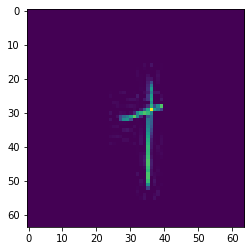

In [3]:
# Example code fyi, if you want to view samples from the dataset
plt.imshow(Xtrain[1].reshape((64,64)))

In [4]:
# normalize 
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [5]:
def gradWloss(X, Y, W, b):
    m = np.size(X, 1)
    n = np.size(X, 0)
    k = np.size(Y, 1)
    grad = np.zeros((k, m))
    gradW = (1/n)*((softmax(W@X.T+b,axis = 0)-Y.T)@X)
    return gradW

def gradbloss(X, Y, W, b):
    m = np.size(X, 1)
    n = np.size(X, 0)
    x0 = np.ones((n, 1))
    gradb = (1/n)*((-Y.T + (softmax(W@X.T+b,axis = 0)))@x0)
    return gradb
    

In [10]:
def graddescent(X, Y, gradWloss, gradbloss, W1, b1, eta, a, tol,maxiter):
    # calculate the gradient
    db = gradbloss(X,Y,W1,b1)
    dw = gradWloss(X,Y,W1,b1)
    norm_w = np.amax(np.absolute(dw))
    norm_b = np.amax(np.absolute(db))
    maxNorm = max(norm_b,norm_w)
    iter = 0
    wb = np.append(W1,b1,axis = 1)
    hist = [wb]
    while maxNormgradnorm > tol and iter < maxiter: 
        W1 = W1 - (eta/(1+a*iter))*dw
        b1 = b1 - (eta/(1+a*iter))*db
        db = gradbloss(X,Y,W1,b1)
        dw = gradWloss(X,Y,W1,b1)
        norm_w = np.max(np.absolute(dw))
        norm_b = np.max(np.absolute(db))
        maxNormgradnorm = max(norm_b,norm_wgradwnorm)
        hist = np.append(hist,[np.append(W1,b1,axis = 1)],axis = 0)
        iter += 1

    return hist

In [11]:
def loss(X,Y,W,b):
    N = X.shape[0]
    Wx_b = X@W.T + b.reshape(1,-1)
    E = np.exp(Wx_b)
    return (1/N)*(-np.sum(Y *(Wx_b))+np.sum(np.log(np.sum(E,axis = 1))))

def steepestdescent(X, Y, loss, gradWloss, gradbloss, W1,b1, alpha1, c, beta, tol,maxiter):
    histcount = [0]
    iter = 0
    hist = [np.append(W1,b1,axis = 1)]
    db = gradbloss(X,Y,W1,b1)
    dw = gradWloss(X,Y,W1,b1)
    norm_w,norm_b = np.amax(np.absolute(dw)),np.amax(np.absolute(db))
    maxNorm = max(norm_w,norm_b)
    count = 1
    while maxNormgradnorm > tol and iter < maxiter:
        alpha  = alpha1
        lossp = loss(Xtrain,Ytrain,W1,b1) 
        diff = loss(Xtrain,Ytrain,W1-alpha*gradw1,b1-alpha*db) - lossp +  \
        c * alpha * (np.sum(np.trace(gradw1@np.transpose(gradw1)))+ np.transpose(db)@db)
        count += count + 2 
        while diff > 0: 
            alpha = alpha*beta
            diff = loss(Xtrain,Ytrain,W1-alpha*gradw1,b1-alpha*gradb1) - lossp+  \
            c * alpha * (np.sum(np.trace(gradw1@np.transpose(gradw1)))+ np.transpose(db)@db)
            count += count 

        W1 = W1 - (eta/(1+a*iter))*dw
        b1 = b1 - (eta/(1+a*iter))*d
        db = gradbloss(X,Y,W1,b1)
        dw = gradWloss(X,Y,W1,b1)
        norm_w = np.max(np.absolute(dw))
        norm_b = np.max(np.absolute(db))
        maxNorm = max(norm_b,norm_w)
        hist = np.append(hist,[np.append(W1,b1,axis = 1)],axis = 0)
        iter += 1
        count += 1
        histcount = np.append(histcount,count)
    return hist,histcount

In [12]:
# def predict(W, b, X):
    
#     m = X.shape[1]
#     Y0 = softmax(np.dot(W.T, X) + b)
#     print(Y0.shape)
#     i = 0
#     Y0=Y0.T
#     for y in Y0:
# #         print(i)
#         ind = np.argmax(y)
#         y = np.zeros(15)
#         y[ind] = 1
#         Y0[i] = y
#         i += 1
    
#     return Y0.T

In [21]:
# calculate the steepestgradient descent
W1 = np.zeros((15,4096))
b1 =np.zeros((15,1))
hist,histcount =  steepestdescent(Xtrain, Ytrain, loss, gradWloss, gradbloss, W1,b1, 1, 0.8, 0.8, 1e-3,300)
# calculate the accuracy for steepesgradient descent
m = np.size(hist,0)
acctrainsg = np.array([])
acctestsg = np.array([])
ytrainindex = np.argmax(Ytrain,axis = 1) 
ytestindex = np.argmax(Ytest,axis = 1)
for i in range(m):
    # calculate the predicted category
    Wxtrain_b = Xtrain@hist[i,...,0:4096].T + hist[i,...,4096].reshape(1,-1)
    ytrainpre = np.argmax(Wxtrain_b,axis = 1)
    Wxtest_b = Xtest@hist[i,...,0:4096].T + hist[i,...,4096].reshape(1,-1)
    ytestpre = np.argmax(Wxtest_b,axis = 1)
    acctrainsg = np.append(acctrainsg,accuracy_score(ytrainindex,ytrainpre))
    acctestsg = np.append(acctestsg,accuracy_score(ytestindex,ytestpre))  

# calculate gradient descent
W1 = np.zeros((15,4096))
b1 =np.zeros((15,1))
hist2 = graddescent(Xtrain, Ytrain, gradWloss, gradbloss, W1, b1, 4, 0.01, 1e-3,300)
hist2 = np.array(hist2)
# calculate the accuracy for gradient descent 
m = np.size(hist2,0)
acctraingg = np.array([])
acctestgg = np.array([])
ytrainindex = np.argmax(Ytrain,axis = 1)
ytestindex = np.argmax(Ytest,axis = 1)
for i in range(m):
    Wxtrain_b = Xtrain@hist2[i,...,0:4096].T + hist2[i,...,4096].reshape(1,-1)
    ytrainpre = np.argmax(Wxtrain_b,axis = 1)
    Wxtest_b = Xtest@hist2[i,...,0:4096].T + hist2[i,...,4096].reshape(1,-1)
    ytestpre = np.argmax(Wxtest_b,axis = 1)
    acctraingg = np.append(acctraingg,accuracy_score(ytrainindex,ytrainpre))
    acctestgg = np.append(acctestgg,accuracy_score(ytestindex,ytestpre))  
    


Text(0, 0.5, 'Percentage of accuracy')

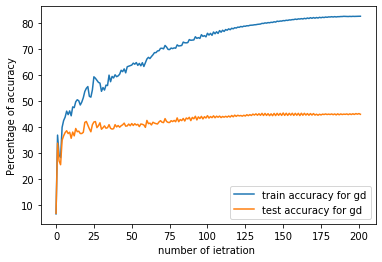

In [22]:
# plot with x-axis to be number of iteration
plt.plot(np.arange(m),100*acctraingg,label = 'train accuracy for gd')
plt.plot(np.arange(m),100*acctestgg,label = 'test accuracy for gd')
plt.legend(loc="lower right")
plt.xlabel('number of ietration ')
plt.ylabel('Percentage of accuracy')




Text(0, 0.5, 'Percentage of accuracy')

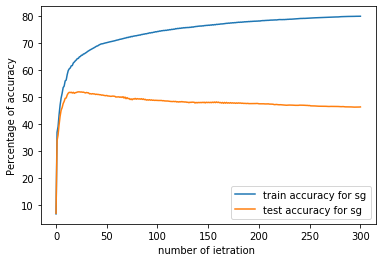

In [24]:

plt.plot(np.arange(301),100*acctrainsg,label = 'train accuracy for sg')
plt.plot(np.arange(301),100*acctestsg,label = 'test accuracy for sg')
plt.legend(loc="lower right")
plt.xlabel('number of ietration ')
plt.ylabel('Percentage of accuracy')